In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.special import gamma

plt.rcParams.update({
    "font.size": 9,
    "figure.dpi": 150,
})

In [2]:
def timeseries_from_spectrum(t, f, spectrum, random_phases=True, random_state=np.random):
    out = 0.
    for fi, si in zip(f, spectrum):
        if random_phases:
            phase = random_state.uniform(0, 2 * np.pi)
        else:
            phase = np.pi
        out += np.sqrt(2 * si * (f[1] - f[0])) * np.cos(2 * np.pi * fi * t + phase)

    out -= np.mean(out)
    return out


def ochi_hubble_spectrum(f, swh_wind, peak_period_wind, shape_wind,
                         swh_swell, peak_period_swell, shape_swell):
    def ochi_component(f, swh, peak_period, shape):
        return (
            swh ** 2 * peak_period * (shape + 0.25) ** shape
            / (4 * gamma(shape) * (peak_period * f) ** (4 * shape + 1))
            * np.exp(-(shape + 0.25) / (peak_period * f) ** 4)
        )

    psd = (
        ochi_component(f, swh_wind, peak_period_wind, shape_wind)
        + ochi_component(f, swh_swell, peak_period_swell, shape_swell)
    )

    return psd

In [3]:
f = np.linspace(1e-5, 3 * np.pi, 100_000)
spectrum = ochi_hubble_spectrum(
    f,
    swh_wind=2,
    peak_period_wind=6,
    shape_wind=1,
    swh_swell=1,
    peak_period_swell=14,
    shape_swell=1
)
t = np.arange(0, 60, 0.1)
np.random.seed(22)
elevation = timeseries_from_spectrum(t, f, spectrum)

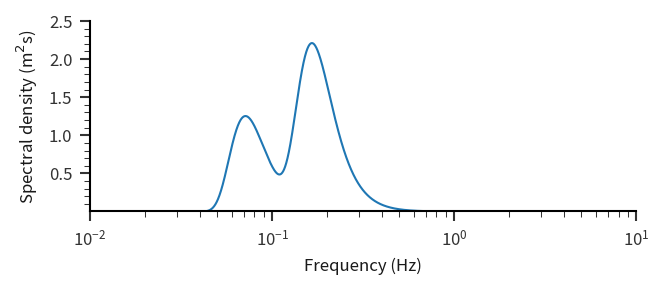

In [4]:
fig = plt.figure(figsize=(4.5, 2))
plt.plot(f, spectrum)
plt.xscale("log")
# plt.yscale("log")
plt.xlim(1e-2, 10)
plt.ylim(1e-2, 2.5)


plt.xlabel("Frequency (Hz)")
plt.ylabel("Spectral density (m$^2$s)")

fig.tight_layout()
plt.savefig("figures/sota/spectrum.pdf")

In [5]:
import math

def find_wave_indices(z, start_idx=0):
    """Generator that yields start and end index of every wave in surface elevation record z."""
    assert start_idx < len(z) - 1
    active = False
    wave_start = start_idx

    for i in range(wave_start, len(z) - 1):
        if math.isnan(z[i]):
            # discard wave if it contains invalid values
            active = False

        if z[i] < 0 and z[i + 1] >= 0:
            if active:
                yield (wave_start, i + 1)

            wave_start = i
            active = True

In [6]:
for i, (wave_start, wave_stop) in enumerate(find_wave_indices(elevation)):
    if i == 10:
        break

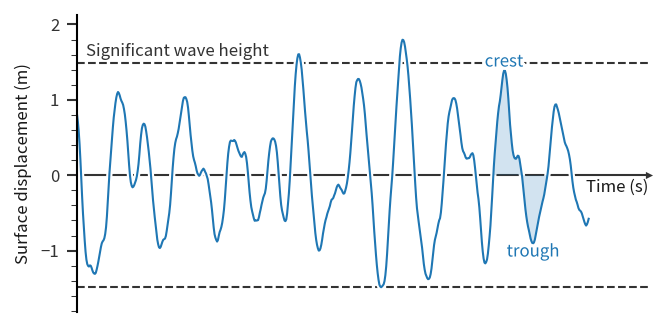

In [7]:
import matplotlib.patheffects as path_effects

outline = [path_effects.Stroke(linewidth=3, foreground='white'),
           path_effects.Normal()]

fig, ax = plt.subplots(1, 1, figsize=(4.5, 2.25))

swh = 4 * np.std(elevation)
plt.plot([t[0], t[-1] + 10], [0.5 * swh, 0.5 * swh], "--", c="0.2")
plt.plot([t[0], t[-1] + 10], [-0.5 * swh, -0.5 * swh], "--", c="0.2")
ax.annotate("Significant wave height", xy=(1, 0.5 * swh + 0.1), ha="left", color="0.2")

plt.plot([t[0], t[-1] + 10], [0, 0], "-", color="0.2")
ax.plot(1, 0, ">", transform=ax.get_yaxis_transform(), clip_on=False, color="0.2", markersize=1)
ax.text(t[-1] + 7, -0.05, "Time (s)", ha="right", va="top")

plt.plot(t, elevation, path_effects=outline)

plt.fill_between(t[wave_start:wave_stop], elevation[wave_start:wave_stop], zorder=4, alpha=0.2)

crest_idx = np.argmax(elevation[wave_start:wave_stop]) + wave_start
trough_idx = np.argmin(elevation[wave_start:wave_stop]) + wave_start
ax.annotate("crest", xy=(t[crest_idx], elevation[crest_idx]), ha="center", va="bottom", color="C0", path_effects=outline)
ax.annotate("trough", xy=(t[trough_idx], elevation[trough_idx]), ha="center", va="top", color="C0", path_effects=outline)


plt.xlim(t[0], t[-1] + 7)
plt.xticks([])
plt.ylabel("Surface displacement (m)")

ax.spines['bottom'].set_visible(False)
fig.tight_layout()
plt.savefig("figures/sota/timeseries.pdf", bbox_inches="tight")

In [8]:
elevation_ensemble = [timeseries_from_spectrum(t, f, spectrum) for _ in range(10)]

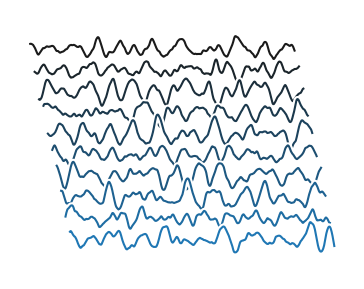

In [9]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list("foo", ["0.1", "C0"])

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))
ax.axis("off")

for i, elevation_i in enumerate(elevation_ensemble):
    c = cmap(i / (len(elevation_ensemble) - 1))
    plt.plot(t + i, elevation_i - 2 * i, color=c, path_effects=outline)
    
fig.tight_layout()
plt.savefig("figures/sota/ensemble.pdf")

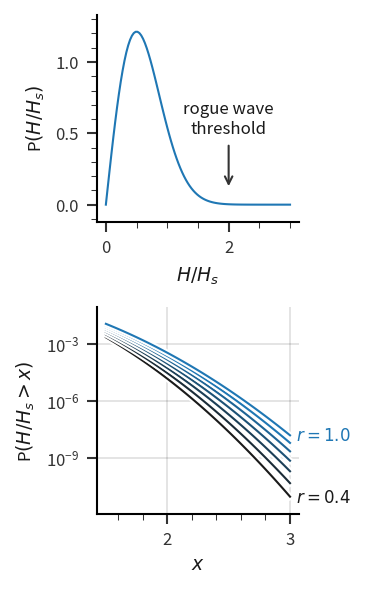

In [10]:
import scipy.stats


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(2.5, 4))

h = np.linspace(0, 3, 100)

ax1.plot(h, scipy.stats.rayleigh(scale=0.5).pdf(h))

ax1.annotate("rogue wave\nthreshold", xy=(2, 0.1), xytext=(2, 0.5), arrowprops=dict(arrowstyle="->", color="0.2"), ha="center")

ax1.set_xlabel("$H / H_s$")
ax1.set_ylabel("P$(H / H_s)$")


def tayfun_cdf(r, h):
    return (
        np.sqrt((1 + r) / (2 * r))
        * (1 + (1 - r**2) / (64 * r * h**2))
        * np.exp(-4 / (1 + r) * h**2)
    )

h = np.linspace(1.5, 3, 100)

endpoints = {}

for i, r in enumerate(np.arange(0.4, 1.01, 0.1)):
    r = round(r, 2)
    sf = tayfun_cdf(r, h)
    c = cmap(i / 5)
    ax2.plot(h, sf, c=c, path_effects=outline)
    if r in (0.4, 1):
        ax2.annotate(f"$r={r}$", xy=(3.05, sf[-1]), color=c, va="center", size=8)
    
ax2.grid()
ax2.set_xlabel("$x$")
ax2.set_ylabel("P$(H / H_s > x)$")
ax2.set_yscale("log")

fig.tight_layout()

plt.savefig("figures/sota/wavedist.pdf")

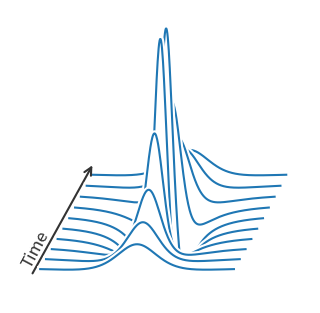

In [11]:
def peregrine_solution(x, t):
    return np.exp(1j * t) * (1 - (4 * (1 + 2j * t)) / (1 + 4 * x**2 + 4 * t**2))

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
ax.axis("off")

x = np.linspace(-5, 5, 400)
for i, t in enumerate(np.linspace(-2, 2, 10)):
    xshift = x - 0.3 * i
    y = np.abs(peregrine_solution(x, t)) - 0.1 * i
    plt.plot(xshift, y, c="C0", path_effects=outline, zorder=2+2*i)
    plt.fill_between(xshift, y, -0.2, color="white", zorder=1+2*i)
    
plt.xlim(-9, 6)
plt.ylim(-0.2, 2.5)
ax.annotate("", xytext=(-5.5 - 0.3 * i, 0), xy=(-5.5 + 0.3 * 2, 0.1 * (i + 2)), arrowprops=dict(arrowstyle="->", color="0.2"))
ax.annotate("Time", (-8.8, 0.1), rotation=62, color="0.2")

plt.savefig("figures/sota/peregrine.pdf", bbox_inches="tight")

In [12]:
from fowd.operators import get_sea_parameters, get_wave_parameters, compute_spectral_density, find_wave_indices

rogue_elev = np.load("rogue-elev.npy")
t = np.arange(0, len(rogue_elev) / 1.28, 1 / 1.28)

In [13]:
tallest_wave = max([slice(s[0], s[1] + 1) for s in find_wave_indices(rogue_elev)], key=lambda s: np.ptp(rogue_elev[s]))

In [37]:
t_dt = 1e9 * t * np.timedelta64(1, "ns")

wave_heights = []
wave_periods = []

for s1, s2 in find_wave_indices(rogue_elev):
    if s1 >= tallest_wave.start:
        break
        
    wave_params = get_wave_parameters(0, t_dt[s1:s2+1], rogue_elev[s1:s2+1], 200, None)
    wave_heights.append(wave_params["crest_height"] - wave_params["trough_depth"])
    wave_periods.append(wave_params["zero_crossing_period"])

wave_params = get_wave_parameters(0, t_dt[tallest_wave], rogue_elev[tallest_wave], 200, None)
sea_params = get_sea_parameters(t_dt, rogue_elev, np.array(wave_heights), np.array(wave_periods), 200)

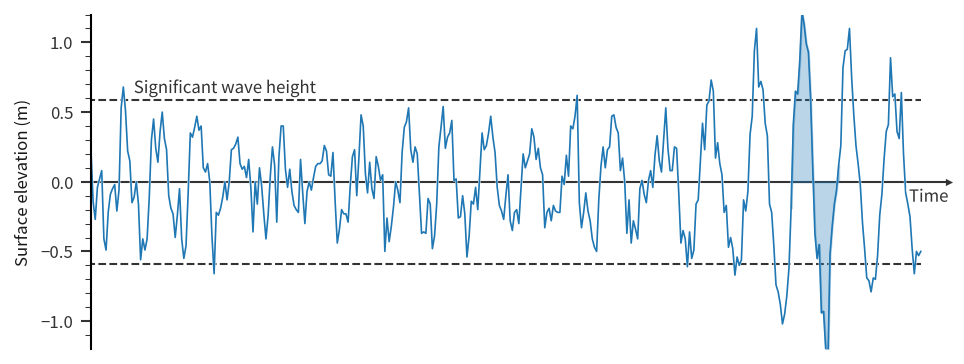

In [72]:
thin_outline = [path_effects.Stroke(linewidth=1.2, foreground='white'),
                path_effects.Normal()]

fig, ax = plt.subplots(1, 1, figsize=(6.5, 2.5))

ax.plot([0, 1], [0, 0], "-", transform=ax.get_yaxis_transform(), clip_on=False, color="0.2")
ax.plot(1, 0, ">", transform=ax.get_yaxis_transform(), clip_on=False, color="0.2", markersize=1)
ax.text(1, -0.05, "Time", transform=ax.get_yaxis_transform(), color="0.2", ha="right", va="top", path_effects=outline)

swh = sea_params["significant_wave_height_spectral"]
ax.plot([t[0], t[-1]], [swh / 2, swh / 2], "--", color="0.2")
ax.plot([t[0], t[-1]], [-swh / 2, -swh / 2], "--", color="0.2")
ax.annotate("Significant wave height", xy=(t[-1] - 300 + 15.5, swh / 2 + 0.05), ha="left", color="0.2", path_effects=thin_outline)

ax.plot(t, rogue_elev, path_effects=thin_outline, linewidth=0.8)
ax.fill_between(t[tallest_wave], rogue_elev[tallest_wave], zorder=5, color="C0", edgecolor="C0", alpha=0.3)

ax.set_xlim(t[-1] - 300, t[-1] + 10)
ax.set_ylim(-1.2, 1.2)
ax.set_xticks([])
ax.spines["bottom"].set_visible(False)

ax.set_ylabel("Surface elevation (m)")

fig.tight_layout()
plt.savefig("figures/main/real-timeseries.pdf", bbox_inches="tight")

In [39]:
f, psd = compute_spectral_density(rogue_elev, t[1] - t[0])

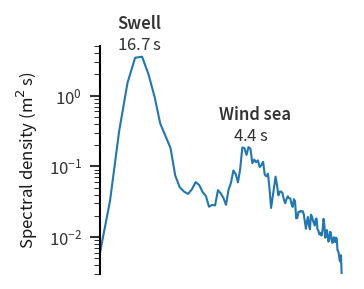

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))

ax.plot(f, psd)

i1 = 12
ax.annotate("Swell", (f[i1], psd[i1]), xytext=(2, 14), textcoords="offset points", ha="center", color="0.2", weight="semibold")
ax.annotate(f"{1/f[i1]:.1f}$\,$s", (f[i1], psd[i1]), xytext=(2, 4), textcoords="offset points", ha="center", color="0.2")

i1 = 45
ax.annotate("Wind sea", (f[i1], psd[i1]), xytext=(2, 14), textcoords="offset points", ha="center", color="0.2", weight="semibold")
ax.annotate(f"{1/f[i1]:.1f}$\,$s", (f[i1], psd[i1]), xytext=(0, 4), textcoords="offset points", ha="center", color="0.2")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(4e-2, 7e-1)
ax.set_ylim(3e-3, 5e0)
ax.set_xticks([])
ax.set_xticks([], minor=True)
ax.spines["bottom"].set_visible(False)
ax.set_ylabel("Spectral density (m$^2\,$s)")

fig.tight_layout()
fig.savefig("figures/main/real-spectrum.pdf")

In [59]:
import json

def sanitize_dict(d):
    out = {}
    
    for k, v in d.items():
        if isinstance(v, np.timedelta64):
            v = v / np.timedelta64(1, "s")
            
        if isinstance(v, np.ndarray):
            v = v.tolist()

        if np.isscalar(v):
            v = float(v)

        out[k] = v
    
    return out


print(json.dumps(sanitize_dict(wave_params), indent=4))
print(json.dumps(sanitize_dict(sea_params), indent=4))

{
    "start_time": 1782.8125,
    "end_time": 1800.0,
    "id_local": 0.0,
    "zero_crossing_period": 16.419270846,
    "zero_crossing_wavelength": 418.83723944317205,
    "maximum_elevation_slope": 0.7680000066757202,
    "crest_height": 1.2200000286102295,
    "trough_depth": -1.309999942779541,
    "height": 2.5299999713897705,
    "ursell_number": 0.05547803960454186,
    "raw_elevation": [
        0.4099999964237213,
        0.6499999761581421,
        0.6299999952316284,
        0.8700000047683716,
        1.2200000286102295,
        1.1299999952316284,
        0.9900000095367432,
        0.9300000071525574,
        0.6000000238418579,
        0.10000000149011612,
        -0.3700000047683716,
        -0.550000011920929,
        -0.44999998807907104,
        -0.9399999976158142,
        -0.9300000071525574,
        -1.2000000476837158,
        -1.309999942779541,
        -0.5199999809265137,
        -0.3199999928474426,
        -0.1599999964237213,
        -0.05999999865889549
 

In [37]:
import scipy.stats

def test_dist(k):
    p = 1 / (1 + 10 ** (3 + 0.1 * (k + 2 * np.cos(2 * np.pi * k))))
    p *= 1 + 2 * scipy.stats.norm(loc=1, scale=0.05).pdf(k)
    p *= 1 + 2 * scipy.stats.norm(loc=-2, scale=0.05).pdf(k)
    return p

def generate_test_data(n):
    x = scipy.stats.norm().rvs(n)
    return x, np.random.rand(n) < test_dist(x)

test_x, test_y = generate_test_data(1_000_000)

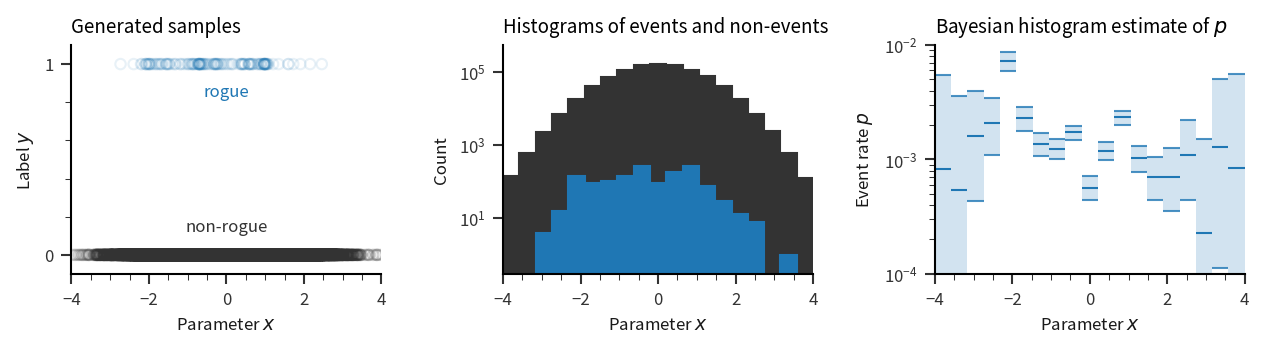

In [55]:
from bayeshist import bayesian_histogram, plot_bayesian_histogram

bins = np.linspace(-4, 4, 20)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8.5, 2.4))

ax1.scatter(x:=test_x[test_y == 0][::10], np.zeros_like(x), alpha=0.1, color="0.2", facecolors="none", rasterized=True)
ax1.scatter(x:=test_x[test_y == 1][::10], np.ones_like(x), alpha=0.1, color="C0", facecolors="none", rasterized=True)
ax1.annotate("rogue", xy=(0, 0.9), color="C0", va="top", ha="center")
ax1.annotate("non-rogue", xy=(0, 0.1), color="0.2", va="bottom", ha="center")
ax1.set_xlabel("Parameter $x$")
ax1.set_ylabel("Label $y$")
ax1.set_yticks([0, 1])
ax1.set_xlim(-4, 4)
ax1.set_title("Generated samples", fontweight="normal", fontsize=10, color="k")

ax2.hist(test_x[test_y == 0], log=True, alpha=1, bins=bins, label="y = 0", facecolor="0.2", edgecolor="0.2")
ax2.hist(test_x[test_y == 1], log=True, alpha=1, bins=bins, label="y = 1", facecolor="C0", edgecolor="C0")
ax2.set_xlabel("Parameter $x$")
ax2.set_ylabel("Count")
ax2.set_xlim(-4, 4)
ax2.set_title("Histograms of events and non-events", fontweight="normal", fontsize=10, color="k")

_, data_dist = bayesian_histogram(
    test_x, test_y, 
    bins=bins,
    x_range=(-4, 4),
    pruning_method=None,
)

plot_bayesian_histogram(bins, data_dist, ax=ax3)
ax3.set_xlabel("Parameter $x$")
ax3.set_ylabel("Event rate $p$")
ax3.set_yscale("log")
ax3.set_ylim(1e-4, 1e-2)
ax3.set_xlim(-4, 4)
ax3.set_title("Bayesian histogram estimate of $p$", fontweight="normal", fontsize=10, color="k")

fig.tight_layout(w_pad=2)
plt.savefig("figures/main/bayesian-histogram.pdf", bbox_inches="tight", dpi=600)